In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from scipy import fftpack
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import pickle
from os import path
from pandas.plotting import autocorrelation_plot

import utilities as util
import models

In [17]:
params = {'id': 'autocorr',
          'path2data': '../data/ID02_1h.mat',
          # model parameters ------------------------
          'channel_size': 60,
          'hidden_size': 0,
          'lambda': 0.5,
          'non-linearity': 'tanh',
          'bias': False,
          # train parameters -------------------------
          'sample_size': 100000,
          'window_size': 10,
          'normalization': True,
          'epochs': 20,
          'lr_decay': 7}

train_set, test_set = util.data_loader(params=params, train_portion=1, windowing=False)

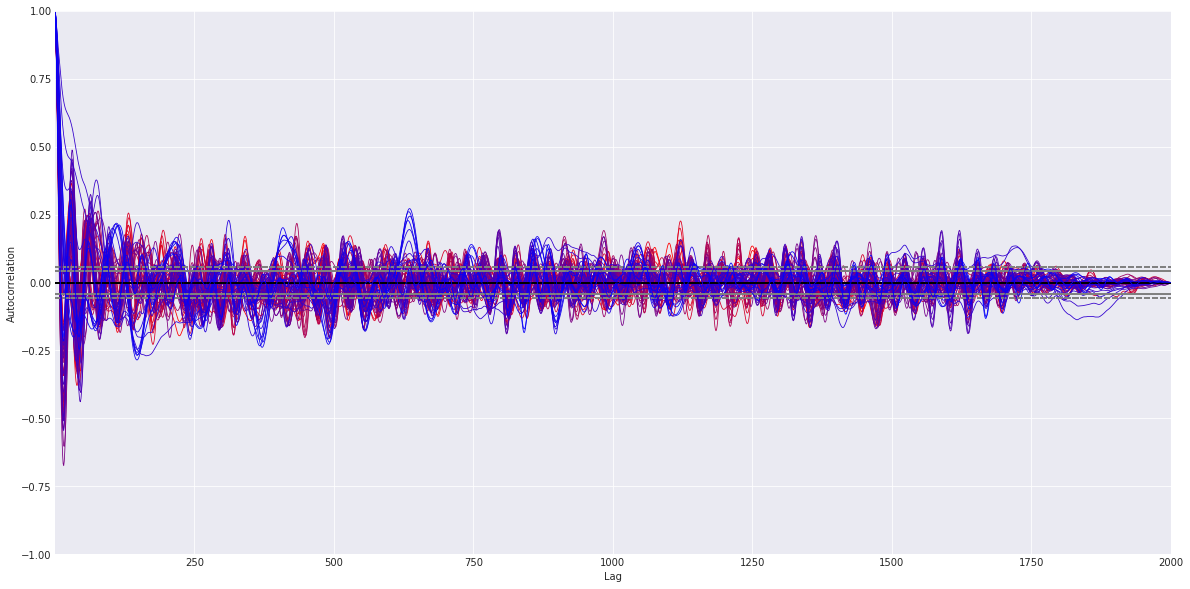

In [35]:
fs = 512
lag = 2000/fs

df = pd.DataFrame(train_set.numpy())
df['Time [s]'] = pd.Series([i/fs for i in range(df.shape[0])])
df.set_index('Time [s]', inplace=True)
#df[0][:50/512].plot()
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
for i in range(params['channel_size']):
    autocorrelation_plot(df[i][:lag], color=(1-i/params['channel_size'],0,i/params['channel_size']), linewidth=.8)

In [18]:
spect = np.zeros((df.shape[0], df.shape[1]))
for i in range(params['channel_size']):
    spect[:, i] = np.abs(fftpack.fft(df[i]))
freq = fftpack.fftfreq(df.shape[0]) * fs


array([ 255.9488 ,  255.95392,  255.95904,  255.96416,  255.96928,
        255.9744 ,  255.97952,  255.98464,  255.98976,  255.99488,
       -256.     , -255.99488, -255.98976, -255.98464, -255.97952,
       -255.9744 , -255.96928, -255.96416, -255.95904, -255.95392])

(0, 2000)

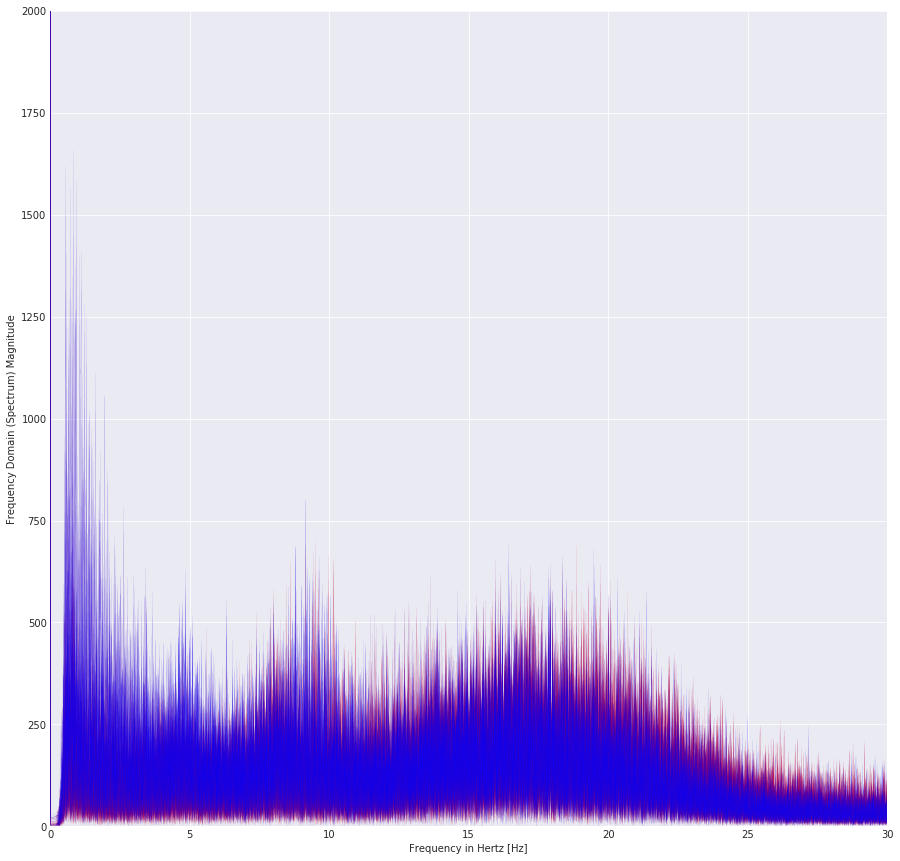

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
for i in range(params['channel_size']):
    ax.plot(freq, np.abs(spect[:,i]), color=(1-i/params['channel_size'],0,i/params['channel_size']), linewidth=.05)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 30)
ax.set_ylim(0, 2000)

In [14]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return  np.array(corr)

def autocorr3(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp,fsize)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

In [61]:
lags = [i for i in range(1000)]
acf = []

for i in range(60):
    x = train_set[60000:80000,i].numpy()
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    acf.append(np.array(corr))

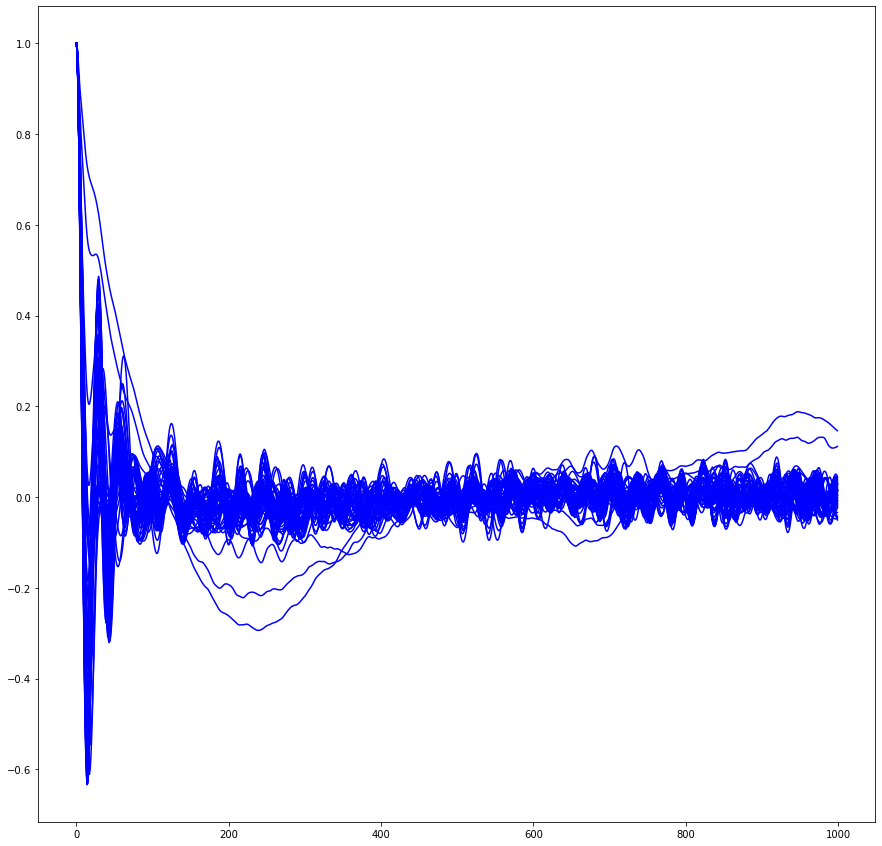

In [62]:
plt.figure(figsize=(15,15))
for i in range(60):
    plt.plot(acf[i], color='b')

In [34]:
2*fs

1024

In [49]:
train_set[:20000,0].shape

torch.Size([20000])